In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p_err):

    error_gate1 = pauli_error([('X', p_err/2), ('Z', p_err/2), ('I', 1 - p_err)])
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [3]:
def process_nodes(nodes):
    output = {"X": [], "Z": []}
    for node in nodes:
        if node[0] >= 0:
            xy_sum = node[1] + node[2]
            if xy_sum % 2 == 0:
                output["X"].append(node)
            elif xy_sum % 2 == 1:
                output["Z"].append(node)

    return output

In [31]:
from qiskit import execute, Aer
from Encoder import SurfaceCode

code = SurfaceCode(3, 1)

# noise_model = get_noise(0.01)
counts = execute(code.circuit['0'], Aer.get_backend('qasm_simulator'), shots=1).result().get_counts()
error_nodes = process_nodes(code.extract_nodes(code.process_results(counts))[0])

print(counts)
print(error_nodes)
print(code.extract_nodes(code.process_results(counts))[])

# Corrected run 1
# 1 1 1
# 1 1 0
# 1 0 0

# Corrected run 2
# 0 0 1
# 1 0 1
# 1 0 0

{'011101110 10100101': 1}
{'X': [(0, -0.5, 0.5), (0, 0.5, 1.5), (0, 1.5, 0.5), (0, 2.5, 1.5)], 'Z': []}
([(-2, 0, 2), (-2, 1, 0), (-2, 1, 2), (-2, 2, 0), (0, -0.5, 0.5), (0, 0.5, 1.5), (0, 1.5, 0.5), (0, 2.5, 1.5)], [(-2, 0, 1), (-2, 0, 2), (-2, 2, 0), (-2, 2, 1)])


In [33]:
print(code.extract_nodes(code.process_results(counts))[1])

[(-2, 0, 1), (-2, 0, 2), (-2, 2, 0), (-2, 2, 1)]


In [32]:
import importlib
import fitters
importlib.reload(fitters)

decoder = fitters.GraphDecoder(3, 1)

error_graph, paths = decoder.make_error_graph(error_nodes["X"], "X")
matching_graph = decoder.matching_graph(error_graph,'X')
matches = decoder.matching(matching_graph,'X')
flips_x = decoder.calculate_qubit_flips(matches, paths,'X')

error_graph, paths = decoder.make_error_graph(error_nodes["Z"], "Z")
matching_graph = decoder.matching_graph(error_graph,'Z')
matches = decoder.matching(matching_graph,'Z')
flips_z = decoder.calculate_qubit_flips(matches, paths,'Z')

print(decoder.net_qubit_flips(flips_x, flips_z))

Physical Qubit: (0.0, 1.0)
Error: X at time: 0
Physical Qubit: (2.0, 1.0)
Error: X at time: 0
{(0.0, 1.0): array([[0, 1],
       [1, 0]]), (2.0, 1.0): array([[0, 1],
       [1, 0]])}


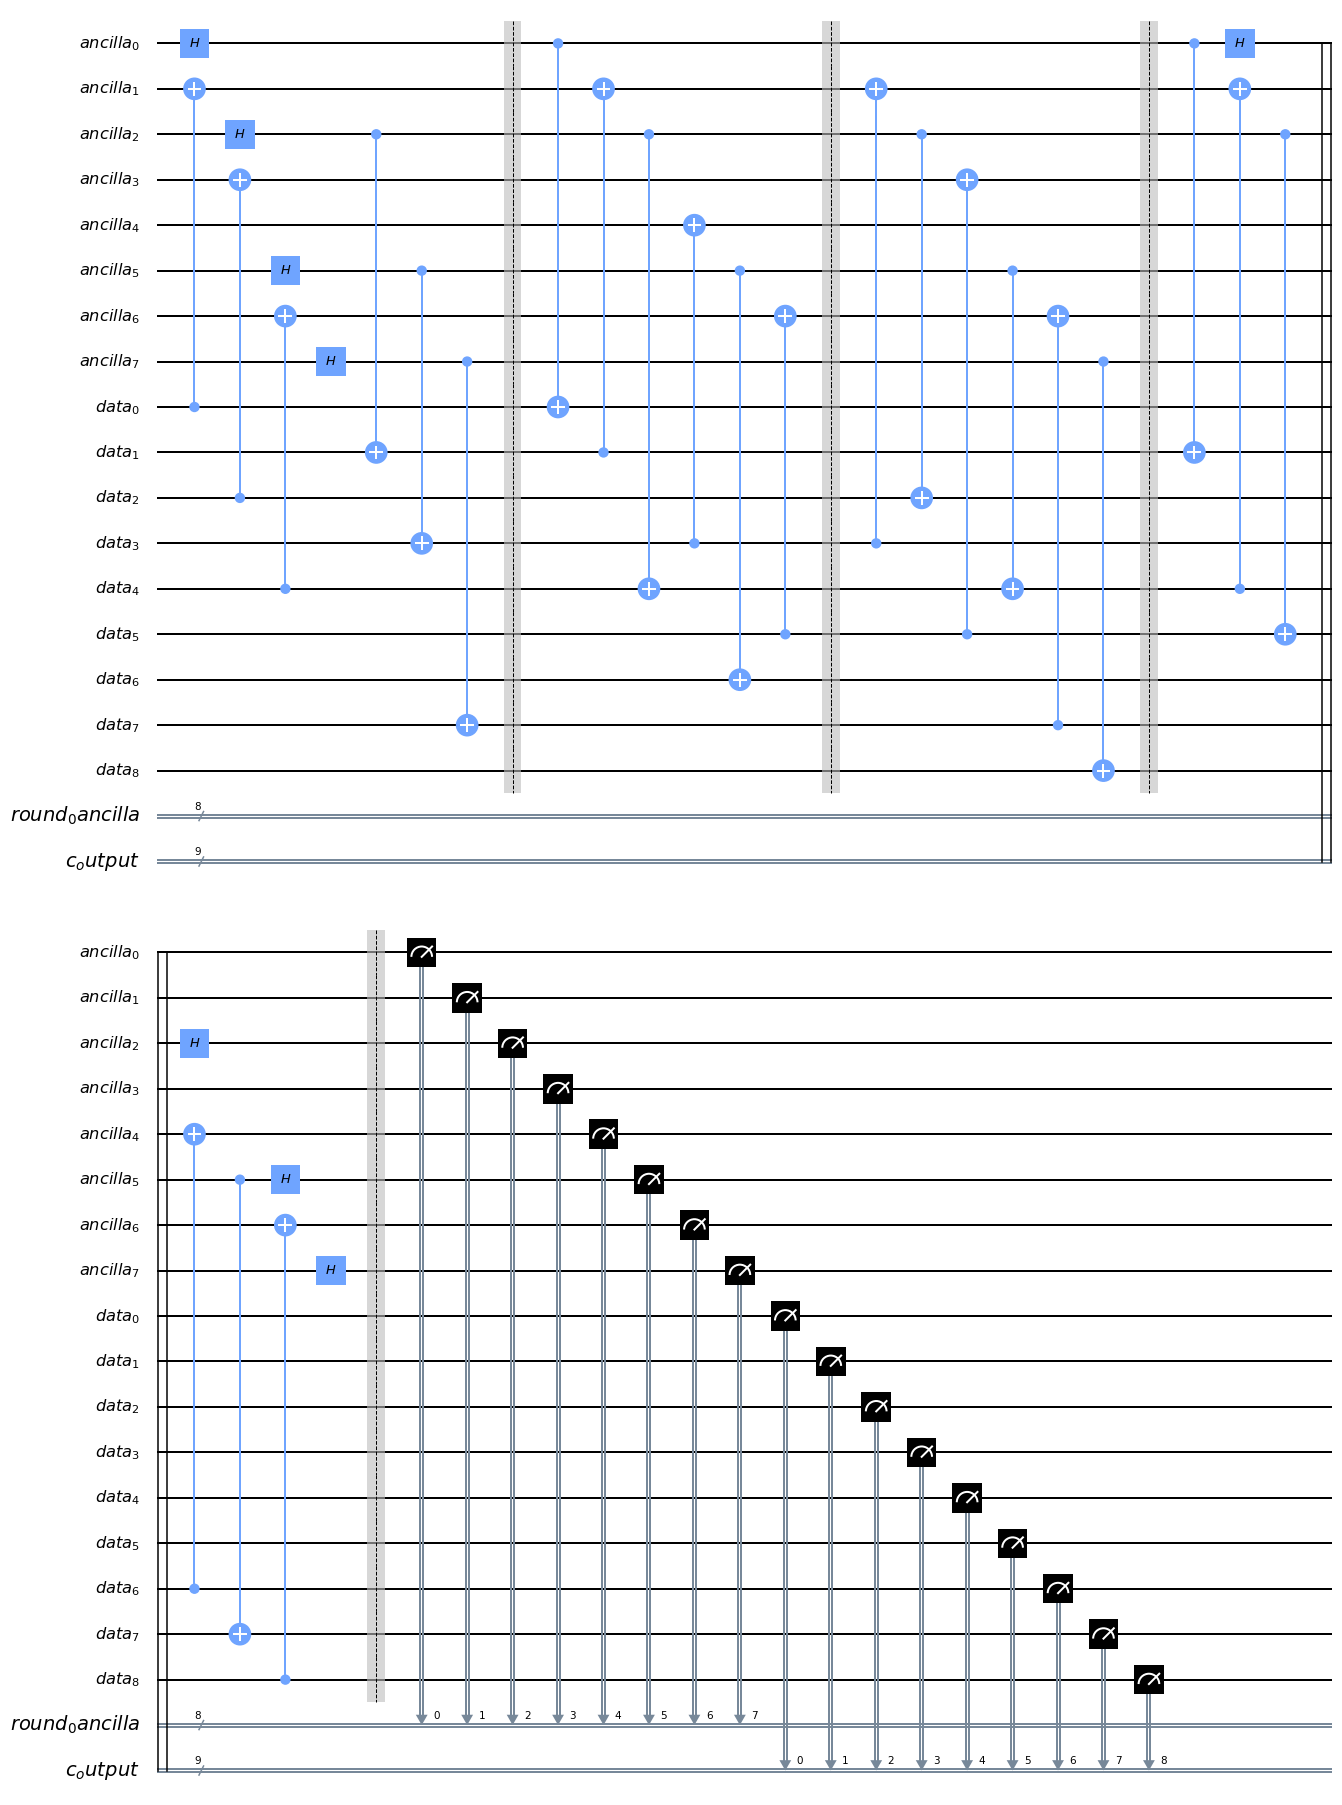

In [29]:
code.circuit['0'].draw(output='mpl')